In [5]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import time
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image
from skimage import io

# Machine learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Libraries imported successfully!")

TensorFlow version: 2.18.0
GPU Available: False
Libraries imported successfully!


Total images found: 12000
Black Rot: 3000 images
ESCA: 3000 images
Healthy: 3000 images
Leaf Blight: 3000 images


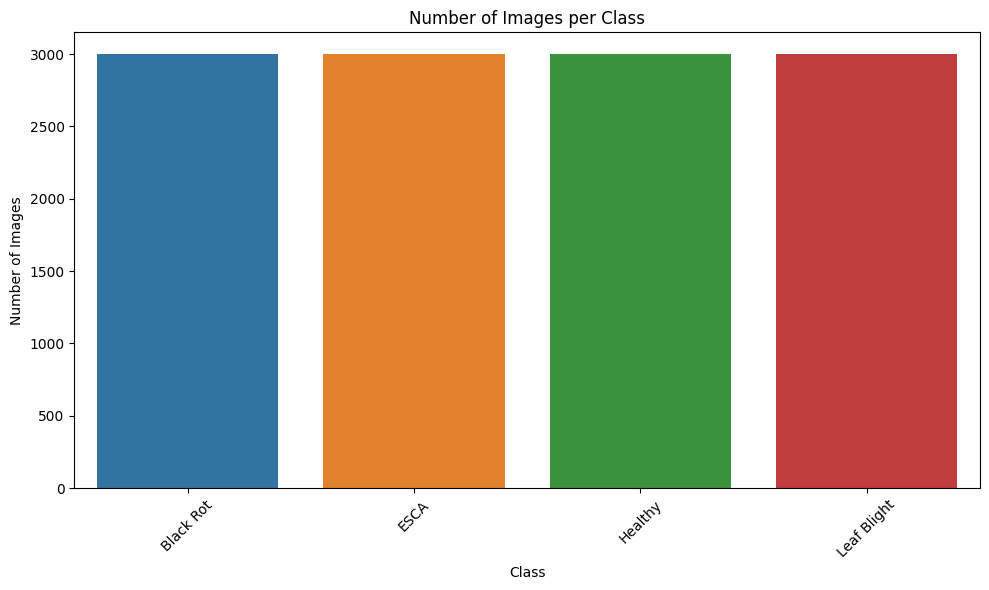

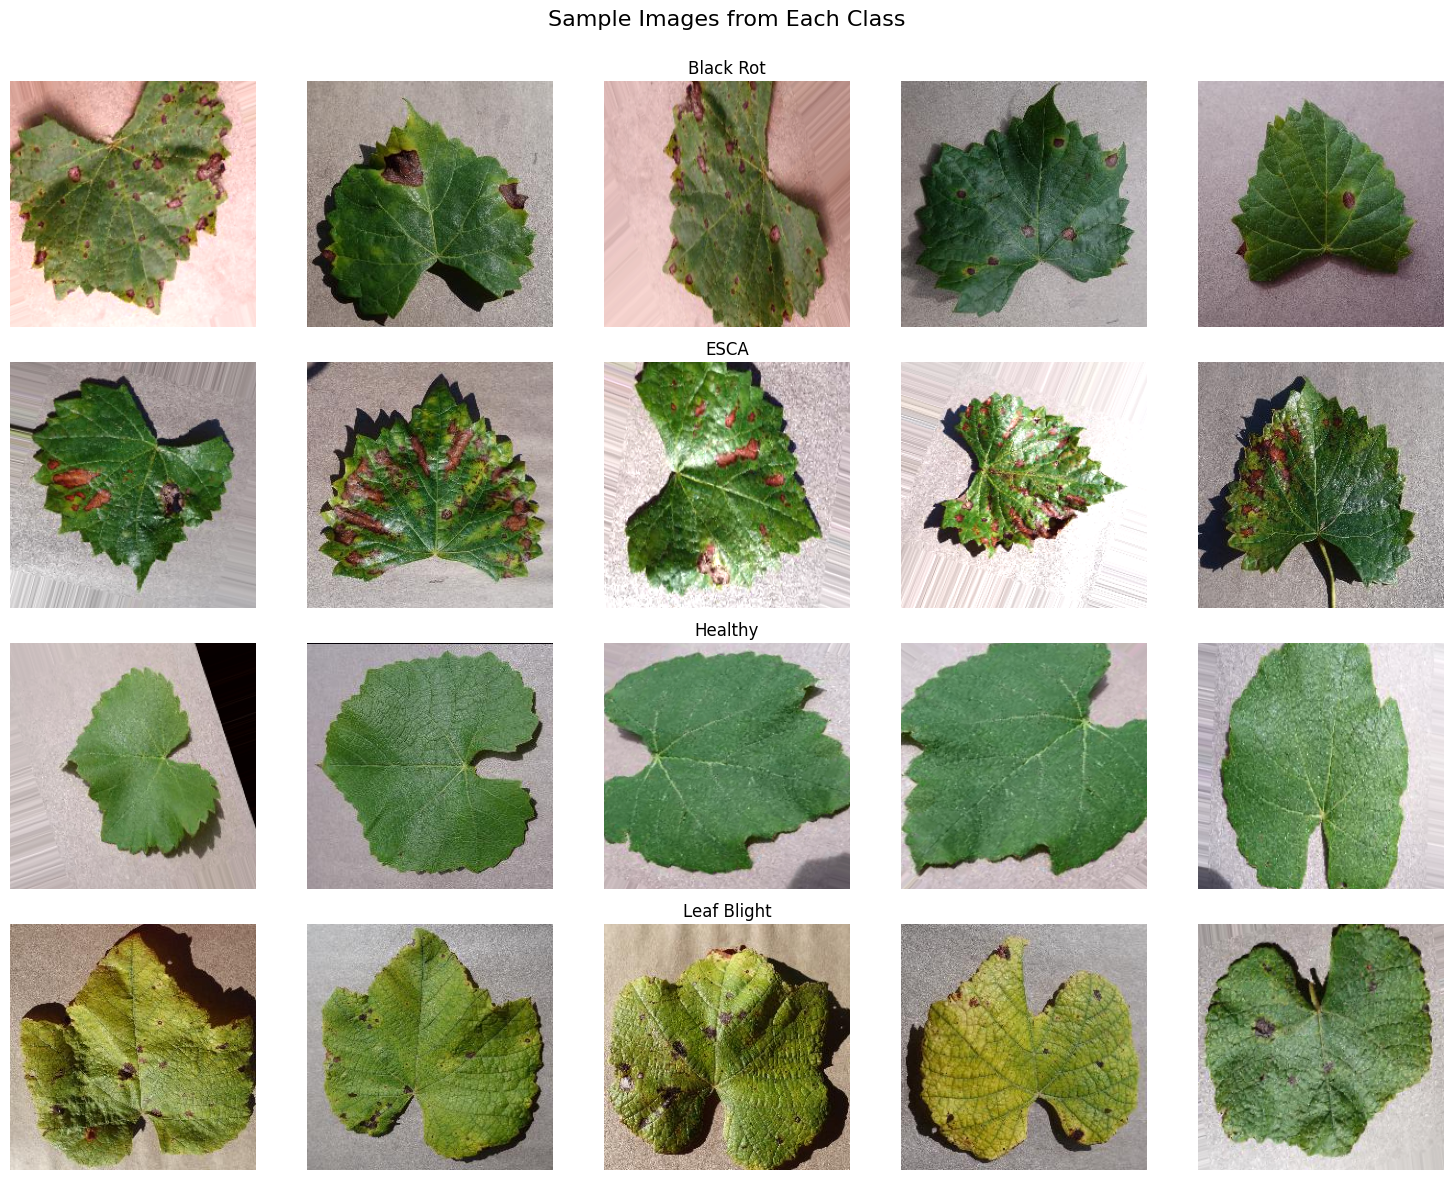

Dataset visualization completed!


In [2]:
# Set the paths
base_dir = '/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data'
classes = ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

# Count the number of images in each class
image_counts = {}
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    image_counts[cls] = len(os.listdir(class_path))
    
print(f"Total images found: {sum(image_counts.values())}")
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize sample images from each class
plt.figure(figsize=(15, 12))
for i, cls in enumerate(classes):
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    
    # Display 5 random images from each class
    for j in range(5):
        if len(images) > j:
            img_path = os.path.join(class_path, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(4, 5, i*5 + j + 1)
            plt.imshow(img)
            plt.title(cls if j == 2 else '')
            plt.axis('off')
            
plt.tight_layout()
plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

print("Dataset visualization completed!")

Found 10200 images belonging to 4 classes.
Found 1800 images belonging to 4 classes.
Class indices: {'Black Rot': 0, 'ESCA': 1, 'Healthy': 2, 'Leaf Blight': 3}
Found 1200 images belonging to 4 classes.
Training samples: 10200
Validation samples: 1800
Testing samples: 1200
Number of classes: 4


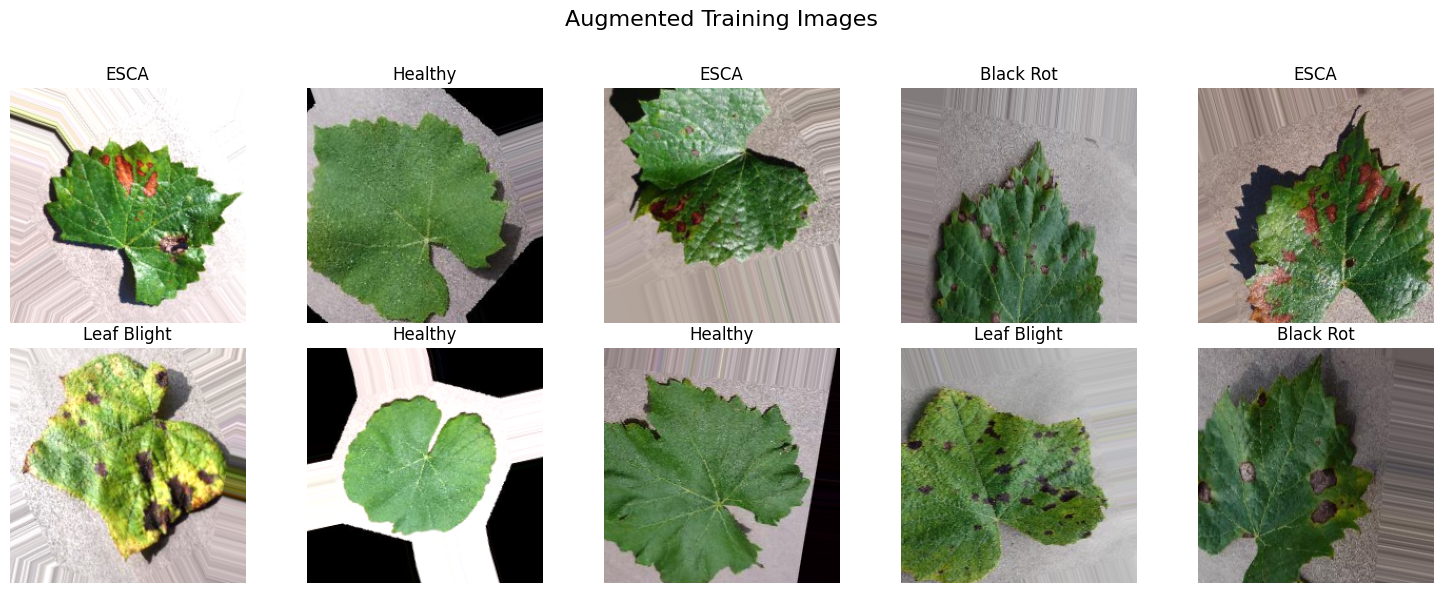

Data preprocessing completed!


In [13]:
# Set image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest',
    validation_split=0.15  # Using 15% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Assuming base_dir is the path to your image directory containing class subfolders
# base_dir = "path/to/your/data"  # Uncomment and set your directory path

# Load training data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Get class indices for later use
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Create a separate test generator using a portion of the data
# Either use a separate test directory if available:
# test_dir = "path/to/test/data"  # Uncomment and set if you have separate test data
# Or use a portion of your main data:
test_split = 0.1  # Using 10% of data for testing
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=test_split
)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # This will take a separate portion as test data
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Testing samples: {test_generator.samples}")
print(f"Number of classes: {len(class_indices)}")

# Visualize augmented images
def show_augmented_images():
    x_batch, y_batch = next(train_generator)
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_batch[i])
        class_name = list(class_indices.keys())[np.argmax(y_batch[i])]
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Augmented Training Images', fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

# Show some augmented training images
show_augmented_images()

print("Data preprocessing completed!")

Custom CNN model created successfully!


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,262,084 (31.52 MB)

 Trainable params: 8,258,564 (31.50 MB)

 Non-trainable params: 3,520 (13.75 KB)

Training the model...
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7827 - loss: 0.6078
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to grape_disease_model_best.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1348s 4s/step - accuracy: 0.7829 - loss: 0.6071 - val_accuracy: 0.2500 - val_loss: 16.1623 - learning_rate: 0.0010
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9268 - loss: 0.2037
Epoch 3: val_accuracy improved from 0.25000 to 0.73208, saving model to grape_disease_model_best.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1335s 4s/step - accuracy: 0.9268 - loss: 0.2037 - val_accuracy: 0.7321 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9512 - loss: 0.137

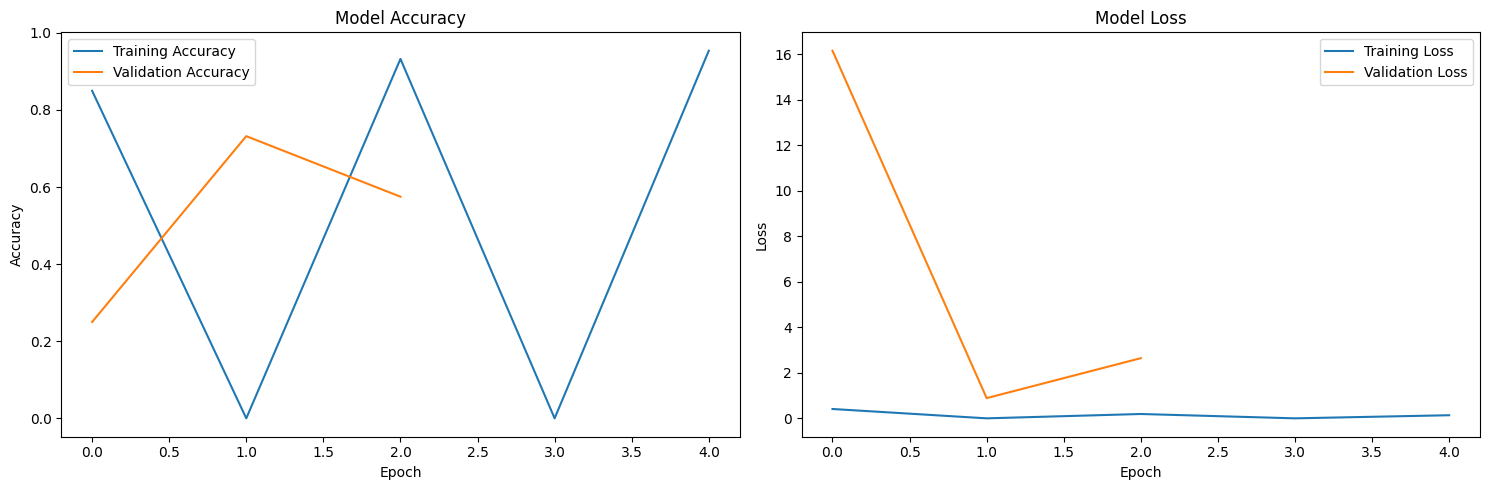

Training history plotted!


In [11]:
# Define a custom CNN model
def create_custom_model():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fifth Convolutional Block
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(len(class_indices), activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Custom CNN model created successfully!")
    return model

# Create model
model = create_custom_model()
model.summary()

# Set up callbacks with .keras extension
checkpoint = ModelCheckpoint(
    'grape_disease_model_best.keras',  # Updated extension
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
print("Training the model...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=5,  # Training for more epochs since we're starting from scratch
    callbacks=callbacks
)

# Save the final model
model.save('grape_disease_final_model.keras')  # Updated extension
print("Model training completed and saved!")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    print("Training history plotted!")

plot_history(history)

Loaded the best model from disk!
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8143 - loss: 0.5526
Test accuracy: 0.8183
Test loss: 0.5493
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step
Classification Report:
              precision    recall  f1-score   support

   Black Rot       0.70      0.94      0.80       300
        ESCA       0.99      0.42      0.59       300
     Healthy       0.89      1.00      0.94       300
 Leaf Blight       0.82      0.91      0.86       300

    accuracy                           0.82      1200
   macro avg       0.85      0.82      0.80      1200
weighted avg       0.85      0.82      0.80      1200



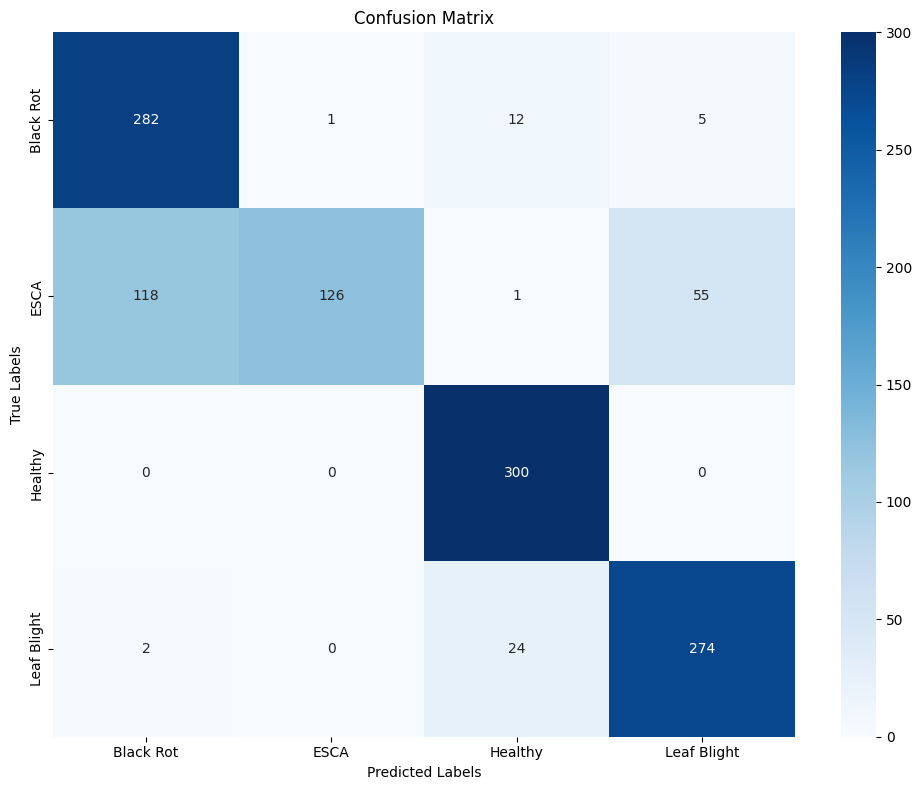

Confusion matrix visualized!


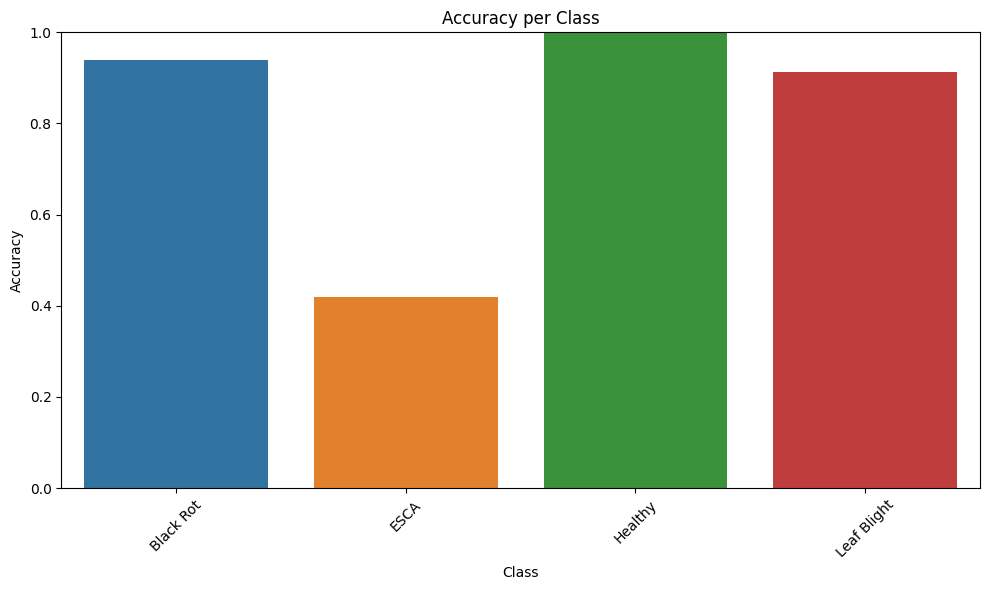

Class-wise accuracy plotted!


In [14]:
# Load best model
try:
    best_model = tf.keras.models.load_model('grape_disease_model_best.keras')  # Updated extension
    print("Loaded the best model from disk!")
except:
    best_model = model
    print("Using the current model for evaluation (best model not found).")

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
test_generator.reset()
predictions = best_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("Confusion matrix visualized!")

# Calculate accuracy per class
class_accuracies = {}
for i, cls in enumerate(class_labels):
    class_indices_test = np.where(y_true == i)[0]
    class_acc = accuracy_score(y_true[class_indices_test], y_pred[class_indices_test])
    class_accuracies[cls] = class_acc
    
# Plot class-wise accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_accuracies.keys()), y=list(class_accuracies.values()))
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("Class-wise accuracy plotted!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


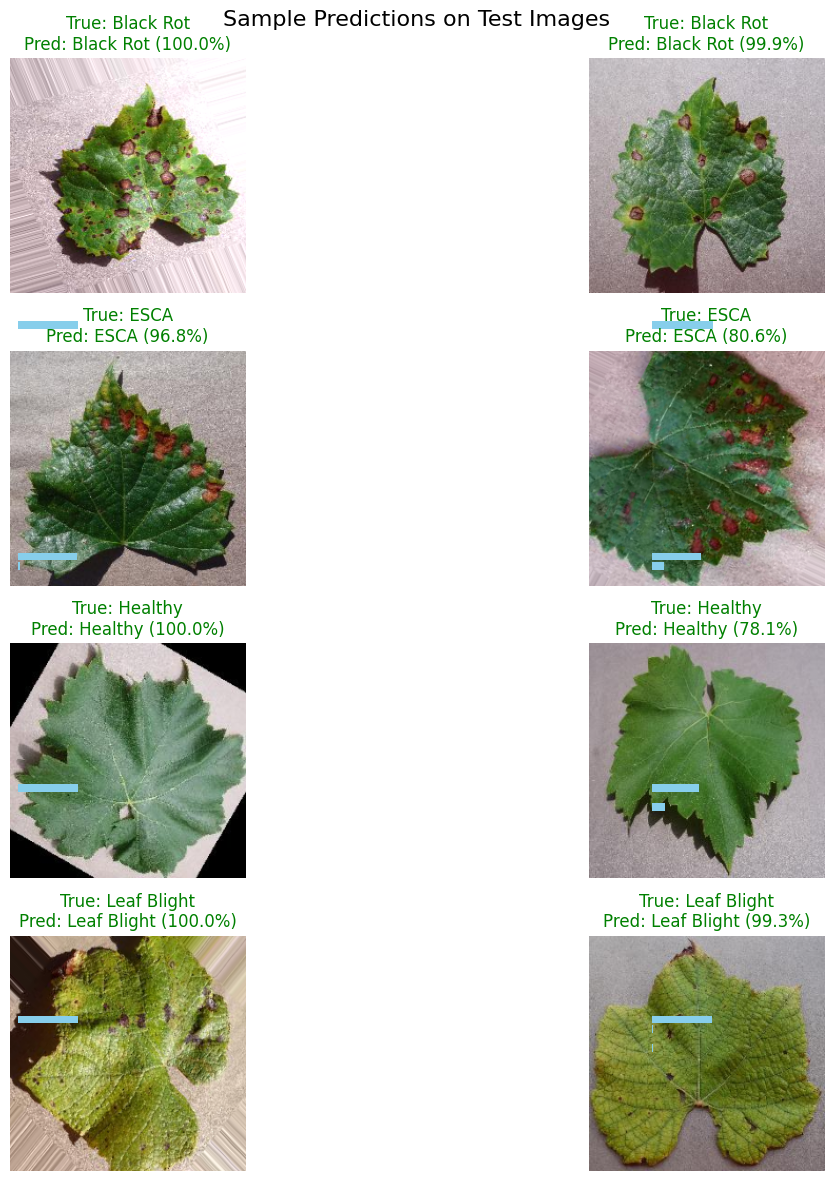

Final model accuracy on test set: 81.83%
Model saved as: 'grape_disease_model_best.keras'
Grape disease classification completed!


In [15]:
# Define a function to make predictions on new images
def predict_disease(image_path, model, class_indices):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Make prediction
    prediction = model.predict(img)
    pred_class = np.argmax(prediction, axis=1)[0]
    
    # Get the class name
    class_names = {v: k for k, v in class_indices.items()}
    predicted_class = class_names[pred_class]
    confidence = prediction[0][pred_class] * 100
    
    return img[0], predicted_class, confidence, prediction[0]

# Get a few sample images from each class
sample_images = []
for cls in class_labels:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    # Get 2 random images from each class
    selected_images = random.sample(images, min(2, len(images)))
    for img_name in selected_images:
        sample_images.append(os.path.join(class_path, img_name))

# Make predictions
plt.figure(figsize=(15, 12))
for i, img_path in enumerate(sample_images):
    img, predicted_class, confidence, all_probabilities = predict_disease(img_path, best_model, class_indices)
    
    # Get true class from path
    true_class = img_path.split(os.sep)[-2]
    
    # Plot the image with predictions
    plt.subplot(4, 2, i+1)
    plt.imshow(img)
    color = 'green' if true_class == predicted_class else 'red'
    plt.title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.1f}%)", color=color)
    plt.axis('off')
    
    # Add a small barplot of all probabilities
    ax = plt.subplot(4, 2, i+1)
    ax_pos = ax.get_position()
    ax2 = plt.axes([ax_pos.x0, ax_pos.y0, ax_pos.width*0.3, ax_pos.height*0.2])
    ax2.barh(class_labels, all_probabilities, color='skyblue')
    ax2.set_xlim(0, 1)
    ax2.axis('off')

plt.tight_layout()
plt.suptitle('Sample Predictions on Test Images', fontsize=16)
plt.subplots_adjust(top=0.94)
plt.show()

# Summary of model performance
print(f"Final model accuracy on test set: {test_acc:.2%}")
print(f"Model saved as: 'grape_disease_model_best.keras'")  # Updated extension
print("Grape disease classification completed!")

# Alternative advanced model (if needed)
def create_advanced_model():
    """Create a more advanced CNN model without requiring pre-trained weights"""
    model = models.Sequential([
        # Enhanced First Block with Residual Connection
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Second Block with Residual Connection
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third Block with Residual Connection
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Fourth Block
        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        # Flatten and Dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        layers.Dense(len(class_indices), activation='softmax')
    ])
    
    # Use a learning rate schedule
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
    
    # Compile with learning rate schedule
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
